# Imbalanced Classification: Microcalcification Classification

### Main techniques used:
* Power Transforms
* Cost Sensitive classification algorithms (class_weights = 'balanced')

### Background:
* The Mammography dataset focuses on detecting breast cancer from radiological scans, specifically the presence of clusters of microcalcifications that appear bright on a mammogram.
* Mammograms were scanned, and images were pre-processed to extract objects/features from the mammogram images. It was eventually reduced to 6 features.

In [1]:
# import necessary libraries

from collections import Counter

from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier

### Simple EDA of the data

In [2]:
filename = 'mammography.csv'
dataframe = read_csv(filename, header=None)
print(dataframe.shape)

# Summarize the class distribution here
target = dataframe.values[:, -1]
counter = Counter(target)
for k, v in counter.items():
    per = v / len(target) * 100
    print(f"Class = {k}, Count = {v}, Percentage = {per:.3f}%")

(11183, 7)
Class = '-1', Count = 10923, Percentage = 97.675%
Class = '1', Count = 260, Percentage = 2.325%


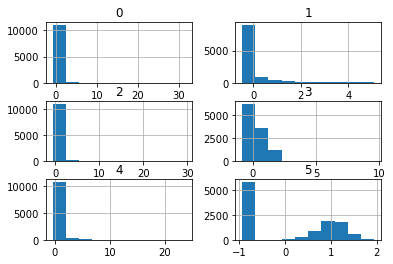

In [3]:
# Visualize the numeric variables with a histogram
dataframe.hist()
pyplot.show()

**Note:** We can see that the variables hav differing scales, and many have an exponential distribution. It may be useful to perform some power transforms before further modelling.

### Evaluate baseline model for reference

In [4]:
# Define a few custom functions
def load_dataset(full_path):
    data = read_csv(full_path, header=None)
    data = data.values
    X, y = data[:, :-1], data[:, -1]
    # perform label encoding on the target variable to get classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y

# Evaluate model
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=88)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

In [5]:
full_path = 'mammography.csv'
X, y = load_dataset(full_path)

# Summarize the dataset
print(X.shape, y.shape, Counter(y))

model = DummyClassifier(strategy = 'stratified')

scores = evaluate_model(X, y, model)

# Summarize baseline model performance
print(f"Mean ROC AUC: {mean(scores):.3f} ({std(scores):.3f})")

(11183, 6) (11183,) Counter({0: 10923, 1: 260})
Mean ROC AUC: 0.502 (0.015)


**Note:** The baseline performance for ROC AUC is 0.5. This provides a lower limit on the skill of subsequent models.

### Evaluate Cost Sensitive models

In [6]:
def get_models():
    models, names = list(), list()
    # Logistic Regression
    models.append(LogisticRegression(solver='lbfgs', class_weight='balanced'))
    names.append('LR')
    # Support Vector Machine classifier
    models.append(SVC(gamma='scale', class_weight='balanced'))
    names.append('SVM')
    # Random Forest
    models.append(RandomForestClassifier(n_estimators=1000, class_weight='balanced'))
    names.append('RF')
    return models, names

In [7]:
full_path = 'mammography.csv'
X, y = load_dataset(full_path)

# Define models here
models, names = get_models()

In [8]:
results = list()

# Evaluate each model here
for i in range(len(models)):
    # Pipeline steps defined
    steps = [('p', PowerTransformer()), ('m',models[i])]
    # Pipeline itself defined
    pipeline = Pipeline(steps=steps)
    # Evaluate pipeline and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # Summarize and store results
    print(f"{names[i]}: {mean(scores):.3f} ({std(scores):.3f})")


LR: 0.923 (0.036)
SVM: 0.957 (0.023)
RF: 0.924 (0.034)


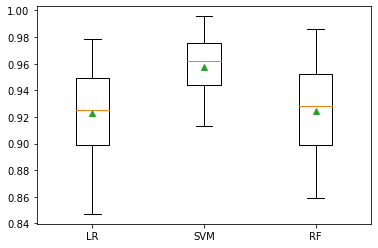

In [9]:
# Visualize above results

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

**Note:** Looking at the results, it seems that cost-sensitive SVM with power transforms applied has the best result at ROC-AUC = 0.95.

### Further steps:
* One can further tune the hyperparameters of the best performing model.
* Standard approaches such as GridSearchCV can be applied.